# Automatic Experiments

In this notebook, we run a bunch of experiments on our different stabilized configurations, to assess the performance of stability training against regular training, on the fast sign perturbation set. 

In [1]:
import sys, os 
sys.path.append(os.getcwd()+'/../src')
sys.path.append(os.getcwd()+'/../data')

import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import architectures
import cifar10
import utils
import perturbations

In [2]:
X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
X_test = numpy.reshape(X_test, [X_test.shape[0], -1])
X_test = X_test/255.
X_test = X_test.astype(numpy.float32)
y_test = utils.labels_to_categoricals(y_test_lab)

In [3]:
stab_nets_name = ['Networks/StabilityTuned1', 'Networks/StabilityTuned2', 'Networks/StabilityTuned3']
stab_grad_files = ['Gradients/stabgradient1.npy', 'Gradients/stabgradient2.npy', 'Gradients/stabgradient3.npy']
pre_rec_values = [0, 0.01, 0.03, 0.1]

In [4]:
if False: # Turn True to compute gradients once and for all
    # Load Regular Net
    net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
    net.load('Networks/RegularTuned')
    gradient = perturbations.compute_fs_grad_sym(net, X_test, y_test)
    numpy.save('Gradients/classgradient', gradient)
    # Load Configuration 1
    net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
    net.load('Networks/StabilityTuned1')
    gradient = perturbations.compute_fs_grad_sym(net, X_test, y_test)
    numpy.save('Gradients/stabgradient1', gradient)
    # Load Configuration 2
    net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
    net.load('Networks/StabilityTuned2')
    gradient = perturbations.compute_fs_grad_sym(net, X_test, y_test)
    numpy.save('Gradients/stabgradient2', gradient)
    # Load Configuration 3
    net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
    net.load('Networks/StabilityTuned3')
    gradient = perturbations.compute_fs_grad_sym(net, X_test, y_test)
    numpy.save('Gradients/stabgradient3', gradient)

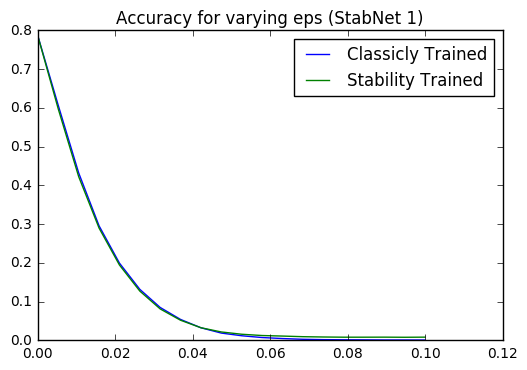

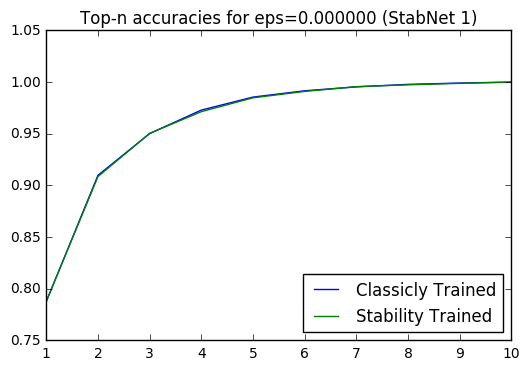

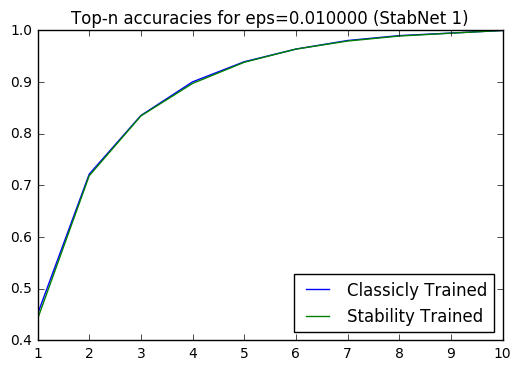

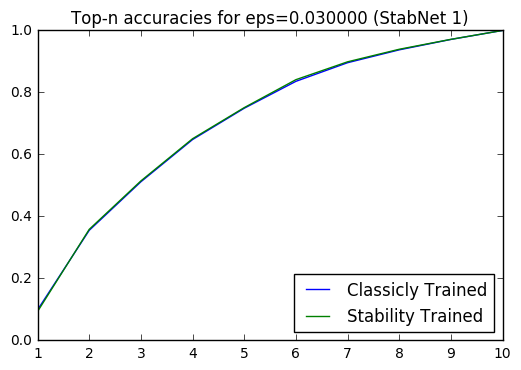

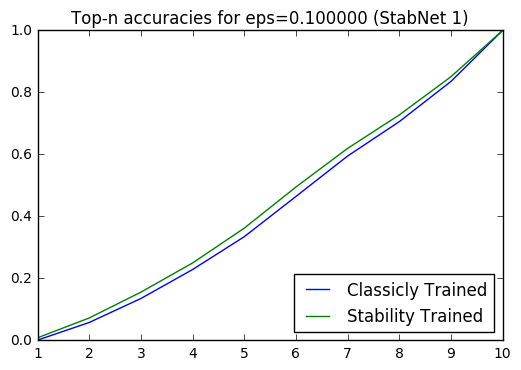

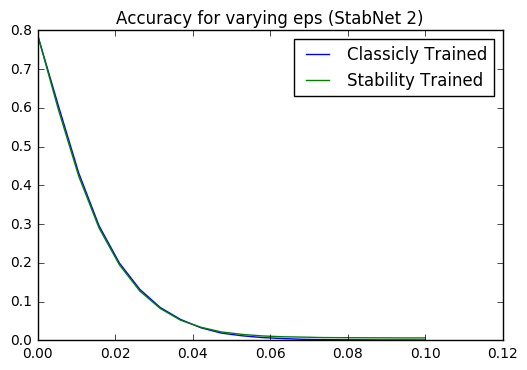

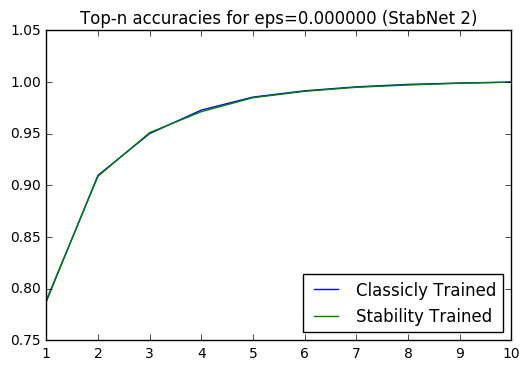

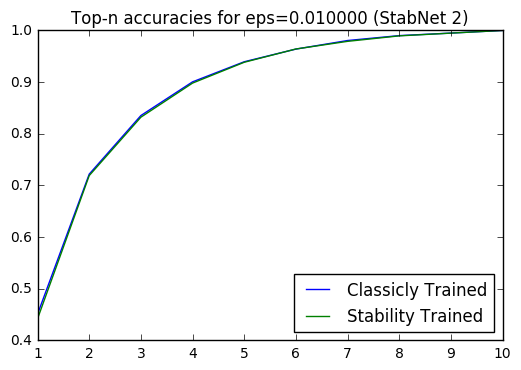

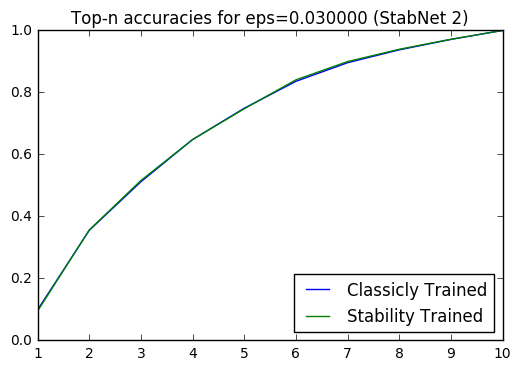

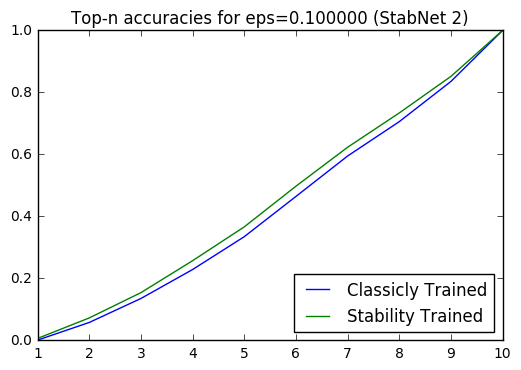

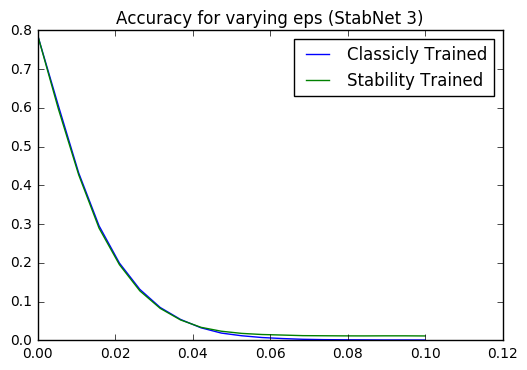

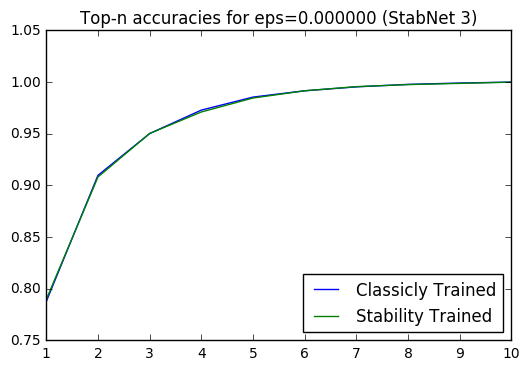

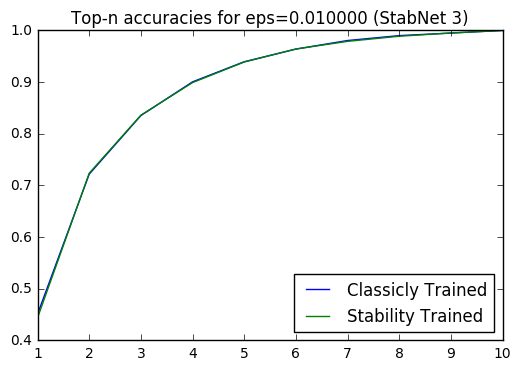

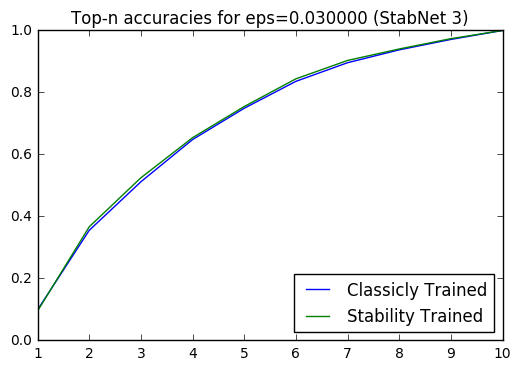

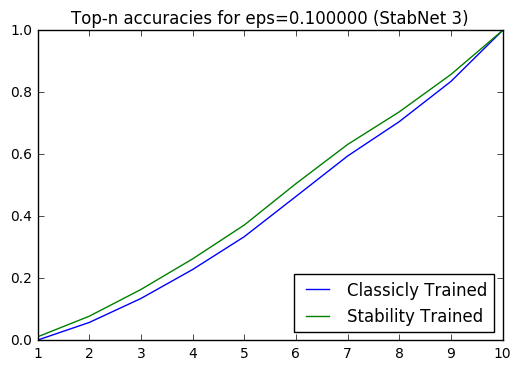

In [5]:
class_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
class_net.load('Networks/RegularTuned')
class_gradient = numpy.load('Gradients/classgradient.npy')

for net_iter in range(0,3):
    stab_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
    stab_net.load(stab_nets_name[net_iter])
    stab_gradient = numpy.load(stab_grad_files[net_iter])
    
    ## Experiment1: Accuracy curve for recomputed perturbation
    epsilons = numpy.linspace(0.0001, 0.1, 20)
    accuracies = numpy.zeros([2,epsilons.shape[0]])
    for epsiter in range(0,epsilons.shape[0]):
        X_stab = X_test + epsilons[epsiter]*numpy.sign(stab_gradient)
        X_stab /= X_stab.max()
        X_class = X_test + epsilons[epsiter]*numpy.sign(class_gradient)
        X_class /= X_class.max()
        accuracies[0,epsiter] = class_net.test(X_class, y_test)
        accuracies[1,epsiter] = stab_net.test(X_stab, y_test)
    plt.plot(epsilons,accuracies[0], label='Classicly Trained')
    plt.plot(epsilons,accuracies[1], label='Stability Trained')
    plt.title("Accuracy for varying eps (StabNet %i)"%(net_iter+1))
    plt.legend()
    plt.savefig('Figures/exp%i-1.pdf'%(net_iter+1))
    plt.show()
    
     ## Experiment2: Top-n curves for recomputed perturbations
    for pr_iter in range(0,4):
        top_ns = numpy.arange(1,11)
        accuracies = numpy.zeros([2, top_ns.shape[0]])
        eps = pre_rec_values[pr_iter]
        X_stab = X_test + eps*numpy.sign(stab_gradient)
        X_stab /= X_stab.max()
        X_class = X_test + eps*numpy.sign(class_gradient)
        X_class /= X_class.max()
        for itr in range(0,top_ns.shape[0]):
            accuracies[0,itr] = class_net.test(X_class, y_test, top=top_ns[itr])
            accuracies[1,itr] = stab_net.test(X_stab, y_test, top=top_ns[itr])
        plt.plot(top_ns,accuracies[0], label='Classicly Trained')
        plt.plot(top_ns,accuracies[1], label='Stability Trained')
        plt.title("Top-n accuracies for eps=%f (StabNet %i)"%(eps, net_iter+1))
        plt.legend(loc=4)
        plt.savefig('Figures/exp%i-2-%i.pdf'%(net_iter+1, pr_iter+1))
        plt.show()
        